In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import torch
import glob
from scipy.io import loadmat
from torch.utils.data import Dataset
from skimage.exposure import rescale_intensity


class OrganSegmentationDataset(Dataset):

  def __init__(
        self,
        images_dir="/content/drive/MyDrive/Research/Image_segmentation/processed_data",
        subset="train",
        traning_patient = 15,
        test_length = 2,
    ):
    self.images_dir = images_dir
    self.subset = subset
    self.traning_patient = traning_patient
    self.data_paths = []
    self.patient_ids = []
    assert subset in ["all", "train", "validation"]

    print("reading {} images...".format(subset))
    filesPath = glob.glob(images_dir+"/*.mat")
    if(subset == "train"):
      for filePath in sorted(filesPath):
        patient_id = int(filePath.split("/")[-1].split("_")[1])
        if patient_id <= traning_patient:
          if patient_id not in self.patient_ids:
            self.patient_ids.append(patient_id)
          self.data_paths.append(filePath)
    
    elif (subset == "validation"):
      for filePath in sorted(filesPath):
        patient_id = int(filePath.split("/")[-1].split("_")[1])
        if traning_patient+test_length >= patient_id > traning_patient:
          if patient_id not in self.patient_ids:
            self.patient_ids.append(patient_id)
          self.data_paths.append(filePath)
    print(sorted(self.patient_ids))
  
  def __len__(self):
    return len(self.data_paths)

  def __getitem__(self, id):
    mat = loadmat(self.data_paths[id])
    mask = mat['seg_img']
    image = mat['main_img']

    #expand dimention
    mask = np.expand_dims(mask, axis = 2)
    image = np.expand_dims(image, axis = 2)
    
    #change shape (C, H, W)
    image = image.transpose(2, 0, 1)
    mask = mask.transpose(2, 0, 1)

    #convert to tensor (1*384*384)
    image_tensor = torch.from_numpy(image.astype(np.float32))
    mask_tensor = torch.from_numpy(mask.astype(np.float32))

    return image_tensor, mask_tensor

In [ ]:
from collections import OrderedDict

import torch
import torch.nn as nn


class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=5, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.softmax(self.conv(dec1), dim=1)
    
    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                ]
            )
        )

  


In [ ]:
def data_loaders():
    dataset_train, dataset_valid = datasets()

    def worker_init(worker_id):
        np.random.seed(42 + worker_id)

    loader_train = DataLoader(
        dataset_train,
        batch_size=1,
        shuffle=True,
        drop_last=True,
        num_workers=2,
        worker_init_fn=worker_init,
    )
    loader_valid = DataLoader(
        dataset_valid,
        batch_size=1,
        drop_last=False,
        num_workers=2,
        worker_init_fn=worker_init,
    )

    return loader_train, loader_valid

def datasets():
    train = OrganSegmentationDataset(
        subset="train"
    )
    valid = OrganSegmentationDataset(
        subset="validation"
    )
    return train, valid

In [ ]:
import torch.nn as nn
import torch

class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred.contiguous().view(-1)
        y_true = y_true.contiguous().view(-1)
        intersection = (y_pred * y_true)
        intersection = intersection.sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

reading train images...
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
reading validation images...
[16, 17]


  0%|          | 0/5 [00:00<?, ?it/s]

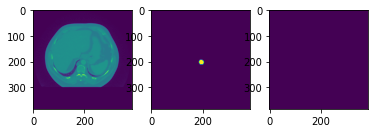

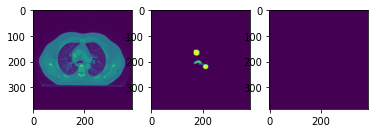

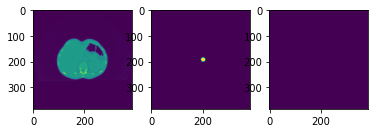

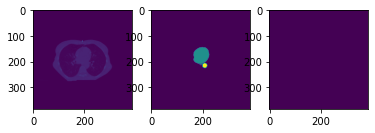

 20%|██        | 1/5 [01:42<06:51, 102.85s/it]

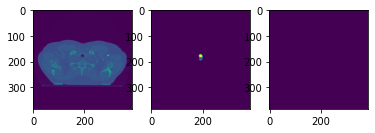

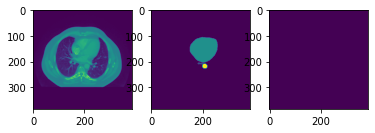

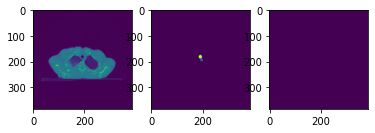

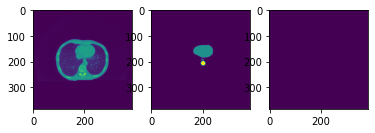

 40%|████      | 2/5 [03:20<04:59, 99.73s/it] 

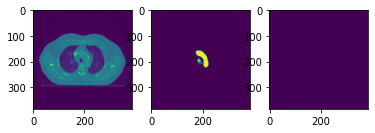

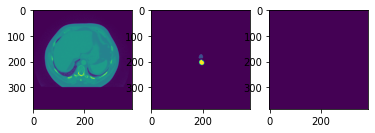

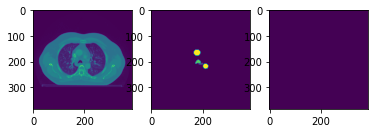

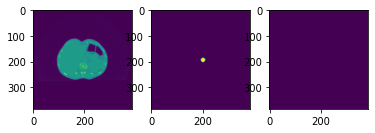

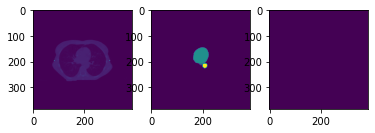

 60%|██████    | 3/5 [04:58<03:17, 98.88s/it]

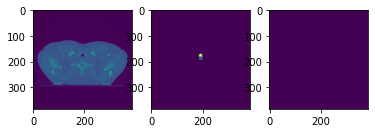

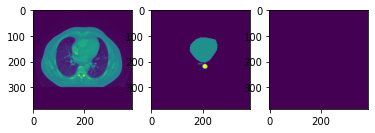

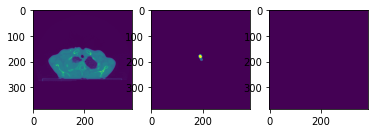

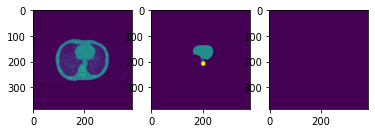

 80%|████████  | 4/5 [06:35<01:38, 98.38s/it]

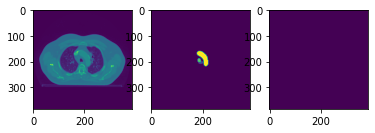

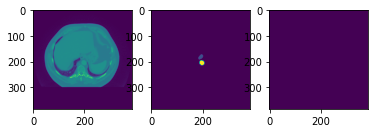

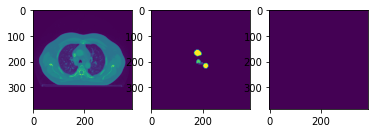

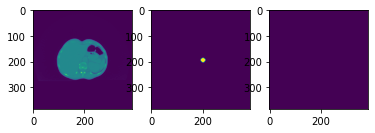

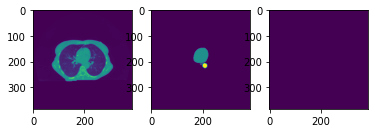

100%|██████████| 5/5 [08:13<00:00, 98.75s/it]


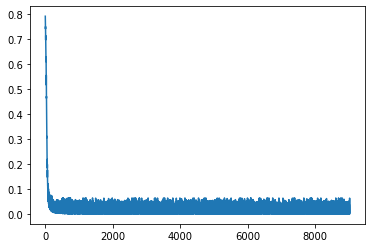

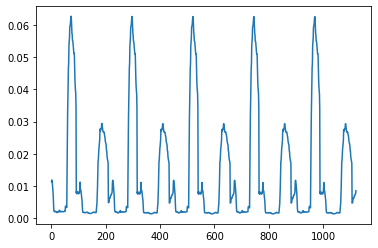

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn.functional import one_hot

device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")



loader_train, loader_valid = data_loaders()
loaders = {"train": loader_train, "valid": loader_valid}

unet = UNet(in_channels=1, out_channels=5)
unet.to(device)
dsc_loss = DiceLoss()
best_validation_dsc = 0.0
optimizer = optim.Adam(unet.parameters(), lr=0.0001)

loss_train = []
loss_valid = []
img_print = 0
step = 0
epoch_num = 5
for epoch in tqdm(range(epoch_num), total=epoch_num):
  for phase in ["train", 'valid']:
    if phase == "train":
      unet.train()
    else:
      unet.eval()

    for i, data in enumerate(loaders[phase]):

      x, y_true = data
      x, y_true = x.to(device), y_true.to(device)

      optimizer.zero_grad()

      with torch.set_grad_enabled(phase == "train"):
        y_pred = unet(x)
        y_pred_cpy = y_pred
        y_true_cpy = y_true
        y_pred = torch.argmax(y_pred, 1).squeeze()
        y_true = y_true.squeeze()

        y_true_test = one_hot(y_true_cpy.type(torch.cuda.LongTensor), 5).squeeze()
        y_true_test = y_true_test.permute(2,0,1)
        y_pred_test = y_pred_cpy.squeeze()

        loss = dsc_loss(y_true_test, y_pred_test)

        if phase == "valid":
          loss_valid.append(loss.item())
          img_print = img_print + 1

          y_pred_np = y_pred.detach().cpu().numpy()
          y_true_np = y_true.detach().cpu().numpy()
          main_image_np = x.detach().cpu().numpy().squeeze()


          if (img_print % 50) == 0:
            plt.figure(img_print)
            plt.subplot(1, 3, 1)
            plt.imshow(main_image_np)
            plt.subplot(1, 3, 2)
            plt.imshow(y_true_np)
            plt.subplot(1, 3, 3)
            plt.imshow(y_pred_np)
            plt.show()

        if phase == "train":
          loss_train.append(loss.item())
          loss.backward()
          optimizer.step()

trl = [i for i in range(1,len(loss_train)+1)]
plt.figure("test loss")
plt.plot(trl, loss_train)
plt.show()

vpl = [i for i in range(1,len(loss_valid)+1)]
plt.figure("Valid loss")
plt.plot(vpl, loss_valid)
plt.show()


In [ ]:
import matplotlib.pyplot as plt


